<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/6_Implementations_of_LMs_part4_becoming_a_backprop_ninja.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

link: https://www.youtube.com/watch?v=q8SA3rM6ckI

- In the previous lectures we use PyTorch default `loss.backward()` to do backprop.

- In this lecture, we are going to implement it by ourselves.

- Reason (Read more in [Andrej's blog](https://karpathy.medium.com/yes-you-should-understand-backprop-e2f06eab496b))

  - it is a leaky abstraction. It can shot your feet if you don't understand the internal.

- Fun history: 10 years ago, everyone in this area wrote the backprop by hand, in Matlab

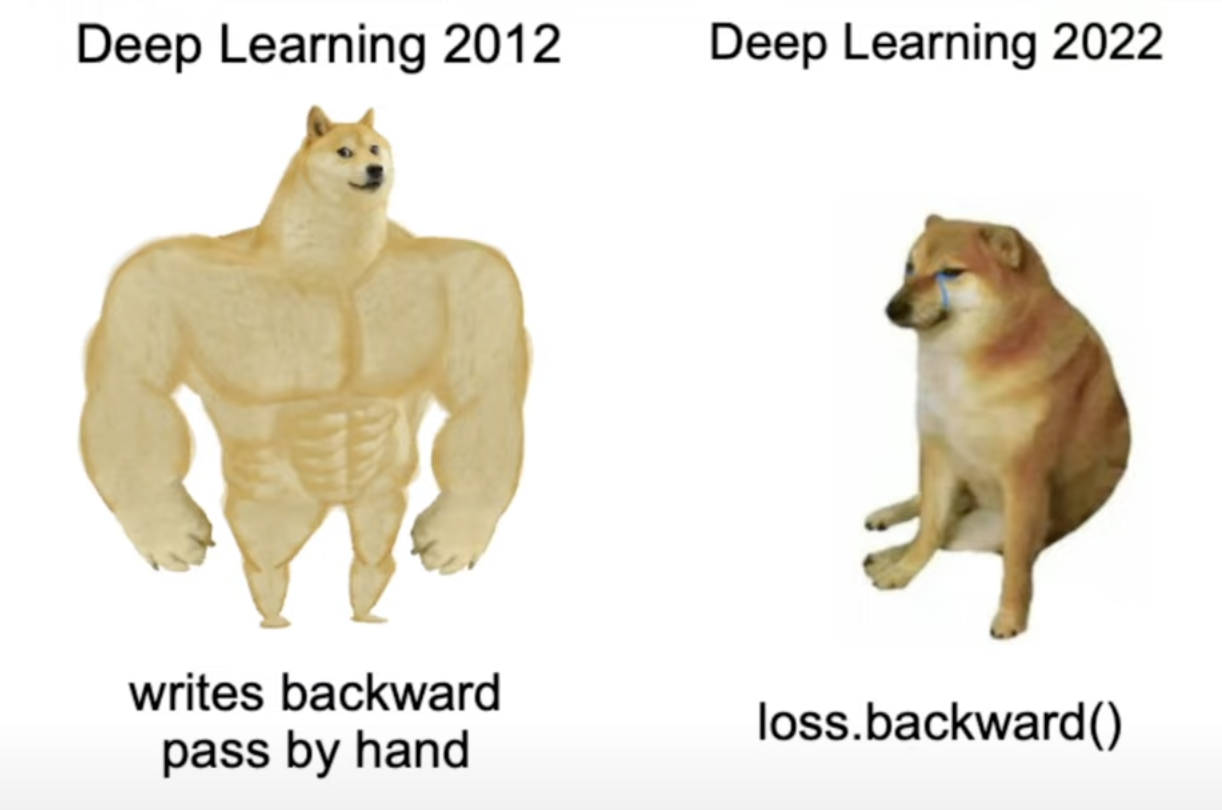

# Setup

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# download the names.txt file from github
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

# read in all the words
words = open('names.txt', 'r').read().splitlines()

--2023-09-18 14:15:10--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.005s  

2023-09-18 14:15:10 (40.3 MB/s) - ‘names.txt’ saved [228145/228145]



In [4]:
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

# Build vocabulary

In [6]:
chars = sorted(list(set(''.join(words))))

In [7]:
stoi = {ch: i+1 for i, ch in enumerate(chars)}
stoi['.'] = 0

itos = {i: ch for ch, i in stoi.items()}

In [8]:
vocab_size = len(stoi)

# Build dataset

In [9]:
block_size = 3  # context length: how many chars do we want to take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(f'{X.shape=}, {Y.shape=}')
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

X.shape=torch.Size([182625, 3]), Y.shape=torch.Size([182625])
X.shape=torch.Size([22655, 3]), Y.shape=torch.Size([22655])
X.shape=torch.Size([22866, 3]), Y.shape=torch.Size([22866])


# Prepare model

In [10]:
# util fn we will use later when comparing manual gradients to PyTorch gradients
#
# s: a string representing the tag used to identify the comparison printed in the log
# dt: the gradient we calculated manually
# t: parameters which we calculate gradient on top of

def cmp(s, dt, t):
  # Check if they are exactly matched
  ex = torch.all(dt == t.grad).item()

  # Check if they are closely matched. It may not be exactually match due to impl details, and closely match might be good enough.
  app = torch.allclose(dt, t.grad)

  maxdiff = (dt - t.grad).abs().max().item()

  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [11]:
n_embd = 10  # the dimensionality of char embedding vectors
n_hidden = 64  # the dimensionality of the neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd))

# Layer 1
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # normalize by kaiming normal
b1 = torch.randn(n_hidden, generator=g) * 0.1 # Using b1 just for fun, it is usefull becasue of BN

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

# Batch Norm
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0 # Gaussian centered at 1.0, because it is used to mul
bnbias = torch.randn((1, n_hidden)) * 0.1 # Gaussian centered at 0.0, because it is used to add

# Note: I am initializing many of these parameters in non-standard ways
# because sometimes initializting with e.g. all zeros could mask an incorrect
# implementation of the backward pass. Instead we give it a small number.

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(f'total params = {sum([p.nelement() for p in parameters])}')

for p in parameters:
  p.requires_grad = True

total params = 4137


In [12]:
batch_size = 32
n = batch_size  # a shorter variable also, for convenience

# Construct a mini-batch
ix = torch.randint(low=0, high=Xtr.shape[0], size=(n, ), generator=g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [13]:
print(f'{Xtr.shape}, {ix.shape} ---> {Xtr[ix].shape}')

torch.Size([182625, 3]), torch.Size([32]) ---> torch.Size([32, 3])


In [77]:
epsilon = 1e-5

emb = C[Xb]

embcat = emb.view(emb.shape[0], -1)

# Linear layer 1

# Weight layer
hprebn = embcat @ W1 + b1

# BN Layer
bnmeani = hprebn.sum(0, keepdim=True) / n
bndiff = hprebn - bnmeani
bndiff2 = bndiff**2
bnvar = bndiff2.sum(0, keepdim=True) / (n-1)
bnvar_inv = (bnvar + epsilon) ** -0.5
# This is equavalent to `(hprebn - hprebn.mean()) / torch.sqrt(hprebn.var()**2 + epsilon)`
bnraw = bndiff * bnvar_inv
hpreact = bnraw * bngain + bnbias

# Activation (non-linearity)
h = torch.tanh(hpreact)

# Linear layer 2
logits = h @ W2 + b2

# cross-entropy loss
logits_maxes = logits.max(dim=1, keepdim=True).values
norm_logits = logits - logits_maxes # Substract max for numerical stability, because exp(A_LARGE_NUM)--->inf, but exp(A_SMALL_NUM)--->doesn't int
counts = torch.exp(norm_logits)
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum ** -1 # If using (1.0/counts_sum) instead then it cannot get backprop to be bit exact...
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# PyTorch backward pass
for p in parameters:
  p.grad = None
for t in [logprobs, probs, counts_sum_inv, counts_sum, counts,  # afaik there is no cleaner way
          norm_logits, logits_maxes, logits, h, hpreact, bnraw,
          bnvar_inv, bnvar, bndiff2, bndiff, bnmeani, hprebn,
          embcat, emb]:
  t.retain_grad()
loss.backward()
loss

tensor(11.7858, grad_fn=<NegBackward0>)

# Exercise 1: backprop through the whole thing manually

- Backpropogating through exactly all of the variables as they are defined in the forward pass above, one by one

In [86]:
# derivative of loss to each params in logprobs.
#
# 1) loss is the -1 * mean of 32 logprobs element, so the derivate value is -1/32
# 2) It is expected to be the same shape as logprobs, so it is initiated with the shape
# 3) Only one element in each row (example) contributes to the loss, so the non-contributing elements should have 0 derivative
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
cmp('logprobs', dlogprobs, logprobs)

dprobs = 1.0 / probs * dlogprobs
cmp('dprobs', dprobs, probs)

# counts shape: (32, 27)
# counts_sum_inv shape: (32, 1)
#
# So when calculating `probs = counts * counts_sum_inv`, there are actually two operations
# 1) broadcast counts_sum_inv to (32, 27)
# 2) then maxmul
#
# We know that if a neuron is used by multiple places in the downstream,
# the neuron's grad should be the sum of grads backpropogated from all the
# usage places. It doesn't matter how the downstream paths merge, e.g. `+`, `*`,
# etc.
#
# E.g. for `logits`, it is `-` (merging place: `norm_logits = logits - logits_maxes`)
# E.g. for `bndiff`, it is `*` (merging place: `bnraw = bndiff * bnvar_inv`)
#
# Operation 1) has broadcast operation.
#
# Here is an intuitive example of the broadcast operation:
#
# c = a * b, but with tensors
# a[3x3] * b[3x1] --->
# a11*b1, a12*b1, a13*b1
# a21*b2, a22*b2, a23*b2
# a31*b3, a32*b3, a33*b3
# c[3x3]
#
# Intuitively, broadcast is equavalent to using each b param/var multiple
# places along the broadcast direction, so here we do a sum along the broadcast
# direction.
#
dcounts_sum_inv = counts * dprobs # handle operation 2)
dcounts_sum_inv = dcounts_sum_inv.sum(1, keepdim=True)  # handle operation 1
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)

# counts is used in two downstream places
# 1) probs
# 2) counts_sum
dcounts = counts_sum_inv * dprobs # downstream 1) for counts

dcounts_sum = (-counts_sum ** -2) * dcounts_sum_inv
cmp('dcounts_sum', dcounts_sum, counts_sum)

# counts_sum are the sum of counts in dim 1.
#
# Here is an intuitive example
#
# a11 a12 a13 ---> b1 (= a11 + a12 + a13)
# a21 a22 a23 ---> b2 (= a21 + a22 + a23)
# a31 a32 a33 ---> b3 (= a31 + a32 + a33)
#
# The derivate of sum to elements on the same row is 1
#
# So here we uses ones matrix
dcounts += torch.ones(counts.shape) * dcounts_sum # downstream 2) for counts
cmp('dcounts', dcounts, counts)

dnorm_logits = torch.exp(norm_logits) * dcounts
cmp('dnorm_logits', dnorm_logits, norm_logits)

# logtis is used in 2 downstream places
# 1) norm_logits
# 2) logits_maxes
dlogits = 1 * dnorm_logits.clone()  # downstream 1) for logtis

# Similar to dcounts_sum_inv, the logits_maxes is broadcast, so the grad is the
# sum of all downstream's grad.
dlogits_maxes = -1 * dnorm_logits.sum(dim=1, keepdim=True)

cmp('dlogits_maxes', dlogits_maxes, logits_maxes)

_tmp = torch.zeros_like(logits)
# Only populate the grad to the indices of the max on each row, because only the
# max we used in the downstream task
_tmp[range(32), logits.max(dim=1).indices] = dlogits_maxes.view(-1)
dlogits += _tmp
cmp('dlogits', dlogits, logits)

dh = dlogits @ W2.transpose(0, 1)
cmp('dh', dh, h)

dhpreact = (1 - torch.tanh(hpreact)**2) * dh
cmp('dhpreact', dhpreact, hpreact)

dbnraw = bngain * dhpreact
cmp('dbnraw', dbnraw, bnraw)

# Similar to dcounts_sum_inv, the bnvar_inv is broadcast, so the grad is the
# sum of all downstream's grad.
#
# bnvar_inv [1,64] * bndiff [32,64] ---> bnraw [32,64]
dbnvar_inv = (bndiff * dbnraw).sum(0, keepdim=True)
cmp('dbnvar_inv', dbnvar_inv, bnvar_inv)

dbnvar = -0.5 * (bnvar + epsilon) ** -1.5 * dbnvar_inv
cmp('dbnvar', dbnvar, bnvar)

# There is sum along the dim 0.
# bndiff2 [32,64] ---> bnvar[1,64]
#
# similar to dcounts above, the derivative from sum to the pre-sum matrix are
# all ones
dbndiff2 = torch.ones_like(bndiff2) * dbnvar / (n-1)
cmp('dbndiff2', dbndiff2, bndiff2)

dbndiff = 2 * bndiff * dbndiff2
dbndiff += bnvar_inv * dbnraw
cmp('dbndiff', dbndiff, bndiff)

# `bnmeani` did broadcast, thus we use grad sum to include the grad impact from
# all the downstreams.
#
# bndiff [32, 64] = hprebn [32, 64] - bnmeani [1,64]
dbnmeani = -1.0 * dbndiff.sum(0, keepdim=True)
cmp('dbnmeani', dbnmeani, bnmeani)

dhprebn = torch.ones_like(hprebn) * dbnmeani / n
dhprebn += 1.0 * dbndiff
cmp('dhprebn', dhprebn, hprebn)

logprobs        | exact: True  | approximate: True  | maxdiff: 0.0
dprobs          | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits_maxes   | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dhpreact        | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
dbnraw          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
dbnvar_inv      | exact: False | approximate: True  | maxdiff: 5.960464477539063e-08
dbnvar          | exact: False | approximate: True  | maxdiff: 7.450580596923828e-09
dbndiff2        | exact: False | approximate: True  | max

In [79]:
bnmeani.shape

torch.Size([1, 64])

In [82]:
hprebn.shape

torch.Size([32, 64])

In [78]:
hprebn.shape

torch.Size([32, 64])

In [83]:
bndiff.shape

torch.Size([32, 64])

In [73]:
_tmp = torch.zeros_like(logits)
_tmp[range(32), logits.max(dim=1).indices] = torch.ones(32)
_tmp.shape

torch.Size([32, 27])

In [74]:
dlogits_maxes.shape

torch.Size([32, 1])